In [36]:
import pytorch_lightning as ptl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import polars as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from typing import Tuple
import torch.optim as optim
from model.peephole_lstm import PeepholeLSTM
from model.data_loader import load_data, prepare_data_loaders
import matplotlib.pyplot as plt

In [73]:
data: pl.DataFrame = load_data("/home/pupperemeritus/isro_project/data/October2023.parquet")

In [66]:
data.shape

(2861526, 65)

In [67]:
data.interpolate()

SVID,Value of the RxState field of the ReceiverStatus SBF block,Azimuth,Elevation,Average Sig1 C/N0 over the last minute (dB-Hz),S4,Correction to total S4 on Sig1 (thermal noise component only) (dimensionless),"Phi01 on Sig1, 1-second phase sigma (radians)","Phi03 on Sig1, 3-second phase sigma (radians)","Phi10 on Sig1, 10-second phase sigma (radians)","Phi30 on Sig1, 30-second phase sigma (radians)","Phi60 on Sig1, 60-second phase sigma (radians)","AvgCCD on Sig1, average of code/carrier divergence (meters)","SigmaCCD on Sig1, standard deviation of code/carrier divergence (meters)",TEC at TOW - 45 seconds (TECU),dTEC from TOW - 60s to TOW - 45s (TECU),TEC at TOW - 30 seconds (TECU),dTEC from TOW - 45s to TOW - 30s (TECU),TEC at TOW - 15 seconds (TECU),dTEC from TOW - 30s to TOW - 15s (TECU),TEC at TOW (TECU),dTEC from TOW - 15s to TOW (TECU),Sig1 lock time (seconds),sbf2ismr version number,Lock time on the second frequency used for the TEC computation (seconds),Averaged C/N0 of second frequency used for the TEC computation (dB-Hz),SI Index on Sig1: (10*log10(Pmax)-10*log10(Pmin))/(10*log10(Pmax)+10*log10(Pmin)) (dimensionless),"SI Index on Sig1, numerator only: 10*log10(Pmax)-10*log10(Pmin) (dB)","p on Sig1, spectral slope of detrended phase in the 0.1 to 25Hz range (dimensionless)",Average Sig2 C/N0 over the last minute (dB-Hz),Total S4 on Sig2 (dimensionless),Correction to total S4 on Sig2 (thermal noise component only) (dimensionless),"Phi01 on Sig2, 1-second phase sigma (radians)","Phi03 on Sig2, 3-second phase sigma (radians)","Phi10 on Sig2, 10-second phase sigma (radians)","Phi30 on Sig2, 30-second phase sigma (radians)","Phi60 on Sig2, 60-second phase sigma (radians)","AvgCCD on Sig2, average of code/carrier divergence (meters)","SigmaCCD on Sig2, standard deviation of code/carrier divergence (meters)",Sig2 lock time (seconds),SI Index on Sig2 (dimensionless),"SI Index on Sig2, numerator only (dB)","p on Sig2, phase spectral slope in the 0.1 to 25Hz range (dimensionless)",Average Sig3 C/N0 over the last minute (dB-Hz),Total S4 on Sig3 (dimensionless),Correction to total S4 on Sig3 (thermal noise component only) (dimensionless),"Phi01 on Sig3, 1-second phase sigma (radians)","Phi03 on Sig3, 3-second phase sigma (radians)","Phi10 on Sig3, 10-second phase sigma (radians)","Phi30 on Sig3, 30-second phase sigma (radians)","Phi60 on Sig3, 60-second phase sigma (radians)","AvgCCD on Sig3, average of code/carrier divergence (meters)","SigmaCCD on Sig3, standard deviation of code/carrier divergence (meters)",Sig3 lock time (seconds),SI Index on Sig3 (dimensionless),"SI Index on Sig3, numerator only (dB)","p on Sig3, phase spectral slope in the 0.1 to 25Hz range (dimensionless)","T on Sig1, phase power spectral density at 1 Hz (rad^2/Hz)","T on Sig2, phase power spectral density at 1 Hz (rad^2/Hz)",Vertical Scintillation Amplitude,Vertical Scintillation Phase,"T on Sig3, phase power spectral density at 1 Hz (rad^2/Hz)",Latitude,Longitude,IST_Time
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs]
5.0,630.0,17.0,67.0,49.4,0.027,0.034,0.017,0.031,0.04,0.04,0.041,-14.596,0.004,12.61,0.01,12.572,0.007,12.591,0.008,12.572,0.016,13911.0,781.0,7834.0,57.4,0.007,0.782,1.8,48.7,0.035,0.037,0.017,0.03,0.039,0.039,0.04,-25.402,0.007,7834.0,0.01,0.93,1.66,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.000027,0.00003,0.020354,0.03827,null,18.777651,78.758218,2023-10-01 05:31:00
11.0,630.0,47.0,20.0,36.2,0.124,0.156,0.039,0.041,0.043,0.043,0.043,-30.136,0.018,19.332,0.089,19.37,0.118,19.77,0.109,19.989,0.078,22104.0,781.0,22100.0,22.1,0.039,3.334,1.31,39.5,0.109,0.106,0.036,0.042,0.054,0.056,0.058,-48.513,0.05,256.0,0.038,2.975,1.51,42.2,0.079,0.077,0.027,0.037,0.056,0.06,0.069,-53.368,0.066,22143.0,0.0

In [80]:
print(data.describe())
column_iter = data.describe().iter_columns()
nan_col_names = []
nan_ratios = []
for col in column_iter:
    try:
        nan_ratio: float = col[1] / col[0]
        nan_ratios.append(nan_ratio)
        if nan_ratio >= 0.4:
            nan_col_names.append(col.name)
    except:
        ...

shape: (9, 66)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ SVID      ┆ Value of  ┆ Azimuth   ┆ … ┆ T on      ┆ Latitude  ┆ Longitude ┆ IST_Time │
│ ---       ┆ ---       ┆ the       ┆ ---       ┆   ┆ Sig3,     ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ f64       ┆ RxState   ┆ f64       ┆   ┆ phase     ┆ f64       ┆ f64       ┆ str      │
│           ┆           ┆ field of  ┆           ┆   ┆ power     ┆           ┆           ┆          │
│           ┆           ┆ …         ┆           ┆   ┆ spectra…  ┆           ┆           ┆          │
│           ┆           ┆ ---       ┆           ┆   ┆ ---       ┆           ┆           ┆          │
│           ┆           ┆ f64       ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 2.861526e ┆ 2.861526e ┆ 2.861526e ┆ … ┆ 1.850672e ┆ 2.861526e 

In [81]:
print(nan_ratios)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00011638501841714277, 0.00023978971211252638, 0.0007463125027977976, 0.0019769738224295137, 0.0033650907859206873, 0.0, 0.0, 0.3971476280686678, 0.3971476280686678, 0.39726565189431173, 0.4056441392319255, 0.39732091845853196, 0.4057677465819005, 0.3860275740209014, 0.39732091845853196, 0.001869626137793547, 0.0, 0.3624147397509158, 0.33614833236288555, 3.494640095753139e-07, 3.494640095753139e-07, 0.004510514881118498, 0.3900889959776927, 0.3905260431523228, 0.3905260431523228, 0.3910262486674415, 0.3916716394827493, 0.3951313454375256, 0.4055889027517168, 0.4167800889124783, 0.3900896712636609, 0.3900896712636609, 0.4176125174815821, 0.3899188448259448, 0.3899188448259448, 0.4360692759747266, 0.5426481877620025, 0.5426772957595224, 0.5426772957595224, 0.5428369934604579, 0.5429734280983073, 0.5434328244698897, 0.5443824442308408, 0.5453132045719038, 0.5426490194038307, 0.5426490194038307, 0.5433495802008629, 0.5426423662943118, 0.5426423662943118

In [52]:
%matplotlib inline

22


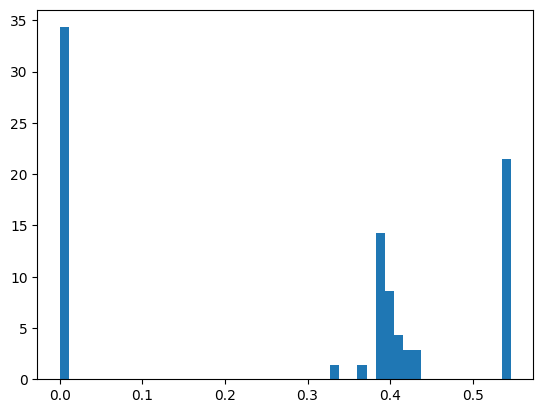

In [82]:
print(len(nan_col_names))
plt.hist(x=nan_ratios,bins=50,density=True,histtype="stepfilled")
plt.show()

In [5]:
class UnidirectionalLSTM(ptl.LightningModule):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        learning_rate: float = 0.001,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.learning_rate = learning_rate

    def forward(
        self, x: torch.Tensor, mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        # Replace NaNs with zeros and create a mask
        if mask is None:
            mask = ~torch.isnan(x)
        x = torch.nan_to_num(x, nan=0.0)

        # Pack the sequence to handle variable-length inputs
        lengths = mask.sum(dim=1).cpu()
        packed_x = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )

        # Process with LSTM
        packed_lstm_out, _ = self.lstm(packed_x)

        # Unpack the sequence
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
            packed_lstm_out, batch_first=True
        )

        # Get the last valid output for each sequence
        idx = (lengths - 1).view(-1, 1).expand(-1, lstm_out.size(2))
        last_valid = lstm_out.gather(1, idx.unsqueeze(1)).squeeze(1)

        out = self.fc(last_valid)
        return out

    def _step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
    ) -> torch.Tensor:
        x, y, mask = batch
        y_hat = self(x, mask)

        # Use masked MSE loss
        loss = nn.MSELoss(reduction="none")(y_hat, y)
        mask = mask[:, -1].unsqueeze(1)  # Use mask for the last time step
        loss = (loss * mask).sum() / mask.sum()

        return loss

    def training_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:
        loss = self._step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> None:
        loss = self._step(batch)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> None:
        loss = self._step(batch)
        loss = torch.log1p(loss)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=10
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [6]:
batch_size = 128
file_path = "/home/pupperemeritus/isro_project/data/October2023.parquet"
train_loader, val_loader, test_loader, target_scaler = prepare_data_loaders(
    file_path,
    batch_size=batch_size,
    sequence_length=60,
    prediction_horizon=1,
    missing_data="interpolate",
    max_gap=1,
    test_size=0.22,
    val_size=0.11,
    stride=30,
)

In [7]:
torch.clear_autocast_cache()
torch.cuda.memory.empty_cache()
input_size = train_loader.dataset.features.shape[1] - 3 # Number of features
print(input_size)
hidden_size = 64
num_layers = 8
output_size = 1  # For regression
logger = TensorBoardLogger("tb_logs", name="gurunet_model")
epochs=100
checkpoint_callback = ModelCheckpoint(
    dirpath=f"checkpoints/version_{logger.version}",
    filename="gurunet-{epoch:02d}-{val_loss:.5f}",
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    verbose=True,
)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=15, mode="min")

lr_monitor = LearningRateMonitor(logging_interval="epoch", log_momentum=True)
model = UnidirectionalLSTM(input_size, hidden_size, num_layers, output_size)
torch.set_float32_matmul_precision("high")
trainer = ptl.Trainer(
    max_epochs=epochs,
    accelerator="gpu",
    devices=1,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        lr_monitor,
    ],
    logger=logger,
    precision="16-mixed",
    enable_progress_bar=True,
    enable_checkpointing=True,
    accumulate_grad_batches=4,
    profiler="simple",
    min_epochs=50,
)
trainer.fit(model, train_loader, val_loader)

# Test the model
trainer.test(model, test_loader)

Using 16bit Automatic Mixed Precision (AMP)


62


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 265 K  | train
1 | fc   | Linear | 65     | train
----------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.063     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: input.size(-1) must be equal to input_size. Expected 62, got 65